# Deep learning
---------------------------

This example shows how we can use ATOM to train and validate a Convolutional Neural Network implemented using [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset with handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym='NN', fullname='Neural network')

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

## Run the pipeline

In [5]:
atom = ATOMClassifier((X_train, y_train), (X_test, y_test), n_rows=0.1, n_jobs=4, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 4 cores.

Dataset stats ================== >>
Shape: (7000, (28, 28, 1), 2)
Scaled: False
-----------------------------------
Train set size: 6000
Test set size: 1000
-----------------------------------
Train set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.1:1.2:1.2:1.2:1.1:1.0:1.2:1.2:1.2:1.2
Test set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.2:1.3:1.4:1.2:1.0:1.1:1.2:1.4:1.4:1.2
-----------------------------------
Distribution of classes:
|    |   dataset |   train |   test |
|---:|----------:|--------:|-------:|
|  0 |       688 |     589 |     99 |
|  1 |       758 |     651 |    107 |
|  2 |       765 |     649 |    116 |
|  3 |       707 |     609 |     98 |
|  4 |       642 |     562 |     80 |
|  5 |       611 |     522 |     89 |
|  6 |       697 |     603 |     94 |
|  7 |       714 |     605 |    109 |
|  8 |       711 |     602 |    109 |
|  9 |       707 |     608 |     9

In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
print(atom.dataset.head())
print(f"\nEvery row in the column contains the data of one image, with shape: {atom.dataset.iloc[0, 0].shape}")
print(f"This can be seen in atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

                                            Features  target
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       9
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       3
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       6
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       5
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       9

Every row in the column contains the data of one image, with shape: (28, 28, 1)
This can be seen in atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [7]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ===================================== >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
Initial point 1 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9508  Best f1_weighted: 0.9508
Time iteration: 17.505s   Total time: 17.511s
Initial point 2 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 256}
Evaluation --> f1_weighted: 0.9432  Best f1_weighted: 0.9508
Time iteration: 10.186s   Total time: 27.704s
Initial point 3 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9566  Best f1_weighted: 0.9566
Time iteration: 15.639s   Total time: 43.348s
Initial point 4 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9465  Best f1_weighted: 0.9566
Time iteration: 18.513s   Total time: 1m:1.865858s
Initial point 5 ---------------------------------
Parameter

## Analyze the results

In [8]:
# We can use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[1.23895105e-09, 7.50470172e-11, 3.59672363e-08, ...,
        1.04067453e-06, 1.37833456e-06, 2.09117889e-06],
       [9.99997497e-01, 1.34576128e-12, 2.11763859e-06, ...,
        6.86806688e-12, 2.02952891e-10, 2.39423805e-08],
       [1.24835531e-10, 8.43449477e-11, 9.85053816e-09, ...,
        3.47881496e-07, 1.73251885e-06, 5.39299617e-06],
       ...,
       [5.35157856e-14, 1.66586105e-14, 6.16249027e-16, ...,
        2.22992960e-14, 2.56814303e-09, 1.90863574e-08],
       [9.59795621e-09, 2.13891701e-15, 1.07965015e-08, ...,
        2.56011011e-11, 1.14306238e-11, 5.34022208e-13],
       [2.81489338e-06, 1.24466442e-12, 1.00715930e-07, ...,
        1.18285152e-05, 9.99813139e-01, 7.43757528e-06]], dtype=float32)

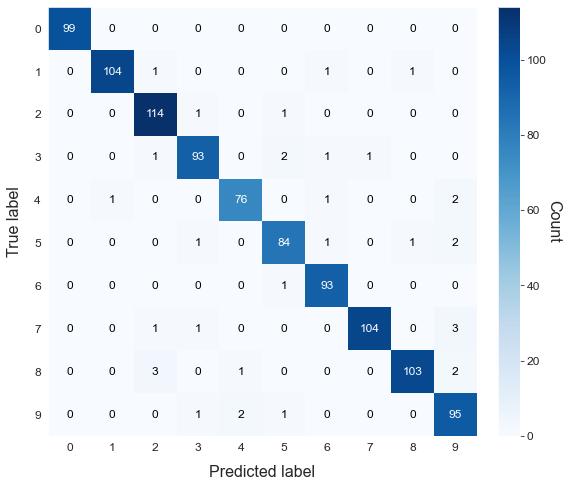

In [9]:
# Or make plots...
atom.nn.plot_confusion_matrix()